# 2. POS tagging with HMMs

## Preparation

In [1]:
import matplotlib.pyplot as plt

from hmm_pos_tagger import HmmPosTaggerInterface, HmmNgramPosTagger, HmmPosTagger, UnsupervisedHmmPosTagger
from dataset import load_dataset_ud_german_gsd, ALL_POS_TAGS

import time

def run_tagging(model: HmmPosTaggerInterface, sentences: list, labels: list) -> tuple[float, float]:
    seconds = time.time()
    predicts = model.tag(sentences)
    seconds = time.time() - seconds

    predicts = [x for xx in predicts for x in xx]
    targets = [x for xx in labels for x in xx]
    assert len(predicts) == len(targets)

    same_cnt = 0
    for pred, targ in zip(predicts, targets):
        same_cnt += targ == pred[0]
    return same_cnt / len(predicts), seconds

In [2]:
# Load datasets
train_set = load_dataset_ud_german_gsd("train", return_labels=True)
dev_set = load_dataset_ud_german_gsd("dev", return_labels=True)
test_set = load_dataset_ud_german_gsd("test", return_labels=True)
words_set = {x for xx in train_set["sentences"] for x in xx}

def report_dataset_info(sentences: list[list[str]]):
    sum_length, max_length, min_length = 0, 0, 1<<31
    for words_list in sentences:
        length = len(words_list)
        sum_length += length
        max_length = max(max_length, length)
        min_length = min(min_length, length)
    return len(sentences), int(round(sum_length / len(sentences))), max_length, min_length

print("| split | sentences | Lavg | Lmax | Lmin |")
print("|-------|-----------|------|------|------|")
for name, subset in zip(["train", "dev", "test"], [train_set, dev_set, test_set]):
    a, b, c, d = report_dataset_info(subset["sentences"])
    print(f"| {name:>5} | {a:>9} | {b:>4} | {c:>4} | {d:>4} |")

| split | sentences | Lavg | Lmax | Lmin |
|-------|-----------|------|------|------|
| train |     13813 |   19 |  117 |    2 |
|   dev |       799 |   16 |   48 |    3 |
|  test |       977 |   17 |   64 |    1 |


## Speed vs. Sentence Length

----

**Analysis:** Fitting each sentence individually is slower than tagging. This is not surprising, as although counting has linear time complexity, we need additional overhead to convert them into log probabilities. This can also be confirmed by comparing the speed of `Tensor` and `Dict` based model: they use the same counting method and data structure, but the latter usually requires more time to convert the counting to log probabilities. However, in the below section `Parallel`, we will see that a poorly designed `Tensor` based model can even cause it to be significantly slower than a `Dict` based one during the fitting process. Although the absolute time complexity trend cannot be observed due to the finite length., by comparing the related trends of the three curves of `Tensor Fitting`, `Tensor Tagging`, and `Dict Tagging`, we can also see the differences in their computational complexity.

In [3]:
def run(model: HmmPosTaggerInterface):
    length_to_fitting_time = dict[int, list[float]]()
    length_to_tagging_time = dict[int, list[float]]()
    for sentence, tags in zip(dev_set["sentences"], dev_set["labels"]):
        length = len(sentence)
        assert len(tags) == length

        fitting_sec = time.time()
        model.fit([sentence], [tags])
        fitting_sec = time.time() - fitting_sec

        _, tagging_sec = run_tagging(model, [sentence], [tags])

        if length not in length_to_fitting_time:
            length_to_fitting_time[length] = list()
            length_to_tagging_time[length] = list()
        length_to_fitting_time[length].append(fitting_sec)
        length_to_tagging_time[length].append(tagging_sec)

    sort_dict = lambda d: zip(*sorted([(x, 1000*sum(y)/len(y)) for x, y in d.items()]))
    return sort_dict(length_to_fitting_time), sort_dict(length_to_tagging_time)

fitting_a, tagging_a = run(HmmPosTagger(ALL_POS_TAGS, (x for xx in dev_set["sentences"] for x in xx)))
fitting_b, tagging_b = run(HmmNgramPosTagger())

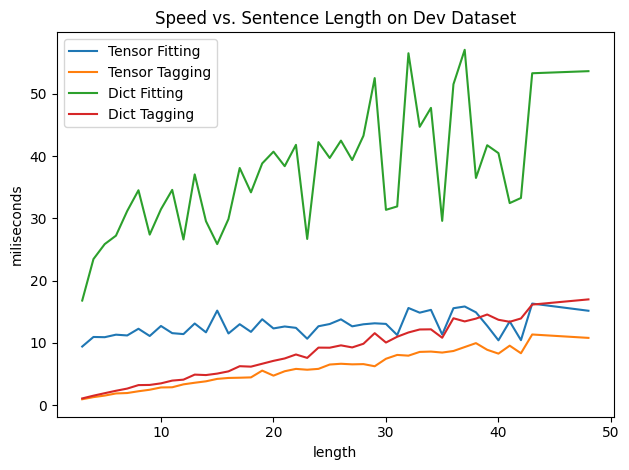

In [4]:
plt.plot(*fitting_a, label=f"Tensor Fitting")
plt.plot(*tagging_a, label=f"Tensor Tagging")
plt.plot(*fitting_b, label=f"Dict Fitting")
plt.plot(*tagging_b, label=f"Dict Tagging")
plt.ylabel("miliseconds"), plt.xlabel("length")
plt.title("Speed vs. Sentence Length on Dev Dataset")
plt.legend(), plt.tight_layout()
plt.show()

## Accuracy vs. Size of Training Dataset

----

**Analysis:** We can see that as the size of the training dataset increases, the model's performance gradually improves, but the rate of improvement slows down. This demonstrates that the model has effectively learned the distribution of the dataset. This also confirms the existence of marginal effects.

In [5]:
all_acc, dataset_sizes = list(), list()
model = HmmPosTagger(ALL_POS_TAGS, words_set)
NUM_SPLIT = 10
div, mod = len(train_set["sentences"])//NUM_SPLIT, len(train_set["sentences"])%NUM_SPLIT
beg = 0
for idx in range(1, NUM_SPLIT+1):
    end = div * idx + min(mod, idx)
    model.fit(train_set["sentences"][beg:end], train_set["labels"][beg:end])
    acc, _ = run_tagging(model, test_set["sentences"], test_set["labels"])
    all_acc.append(acc)
    dataset_sizes.append(end)
    beg = end
assert dataset_sizes[-1] == len(train_set["sentences"])

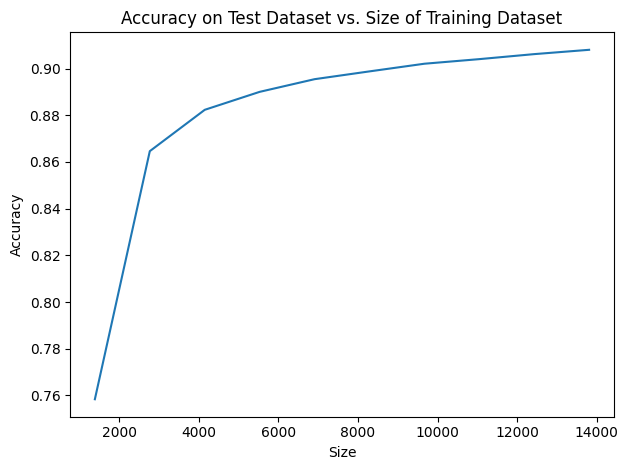

In [6]:
plt.plot(dataset_sizes, all_acc)
plt.title("Accuracy on Test Dataset vs. Size of Training Dataset")
plt.ylabel("Accuracy"), plt.xlabel("Size")
plt.tight_layout()
plt.show()

## N-Gram: Accuracy vs. Number of Previous States

----

**Analysis:** We can see that as N increases, the performance becomes worse and worse. Furthermore, the model has a higher probability of failing to tag a sentences (because it's more likely to encounter unseen state combinations). Therefore, it is unnecessary to incorporate N-grams into HMM.

In [7]:
all_acc, all_failure_rate, all_n_previous_states = list(), list(), list()
test_size= len(test_set["sentences"])
for n_previous_states in range(1, 10+1):
    model = HmmNgramPosTagger(n_previous_states)
    model.fit(train_set["sentences"], train_set["labels"])

    num_failed, same_cnt, total_length = 0, 0, 0
    for sentence, target in zip(test_set["sentences"], test_set["labels"]):
        try:
            predict = model.tag([sentence])[0]
        except RuntimeError:
            num_failed += 1
            continue
        assert len(predict) == len(target)
        total_length += len(predict)
        for pred, targ in zip(predict, target):
            same_cnt += targ == pred[0]

    all_acc.append(same_cnt / total_length)
    all_failure_rate.append(100 * num_failed / test_size)
    all_n_previous_states.append(n_previous_states)
    if all_failure_rate[-1] > 90:
        print(
            f"Early stop at {n_previous_states} because failure rate",
            f"{all_failure_rate[-1]:.2f}% is extremely high",
        )
        break

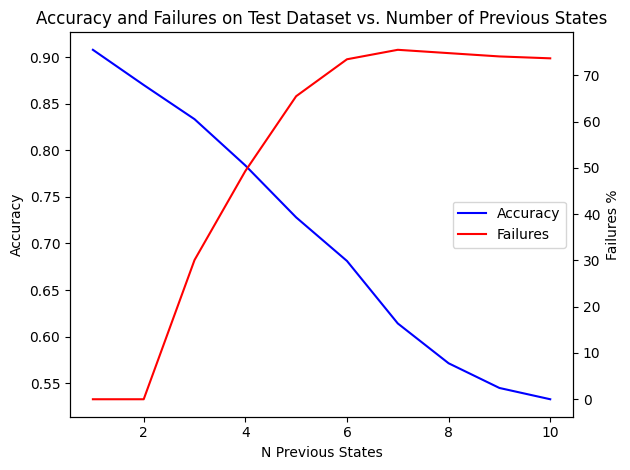

In [8]:
line_a, = plt.plot(all_n_previous_states, all_acc, c="b", label="Accuracy")
plt.ylabel("Accuracy"), plt.xlabel("N Previous States")
plt.twinx(), plt.ylabel("Failures %")
line_b, = plt.plot(all_n_previous_states, all_failure_rate, c="r", label="Failures")
plt.legend([line_a, line_b], [line_a.get_label(), line_b.get_label()], loc="center right")
plt.title("Accuracy and Failures on Test Dataset vs. Number of Previous States")
plt.tight_layout()
plt.show()

## Parallel: Speed vs. Number of Threads

**IMPORTANT**: To ensure the code produce correct results, you must use python3.14t or later version with free-threaded mode. Otherwise, GIL will limit the performance of multithreading. This will lead to a result that the speed decreases as the number of threads increases!

Jupyter also has some unknown issues resulting in poor parallel performance. Therefore, we will use Python to execute an external script, `./measure_multithreading.py`.

The script will print a table where the `N` column represents the number of threads, with the exception of `DP` and `PT`, which represent the performance of the PyTorch Tensor. Because PyTorch will automatically utilize all the cores on a CPU for computation, testing their multithreading is unnecessary and will generally be slower.

`DP` is a deprecated version. Due to design flaws, it has an extremely high cache missing rate, so its training speed is usually the slowest.

`PT` is a cache-optimized version for matrix writing, utilizing the Locality of Reference principle. It should achieve the fastest speed in every operations.

----

**Analysis:** We can see that, generally, tagging speeds up as the number of threads increases, with some exceptions: The speed when `N=1` is slower than the speed when `N=0`. The same for `N>8` and `N=8`. This is because thread switching requires additional overhead.
- When `N=1`, the overhead increases, but only one thread is tagging like `N=0` (without multithreading).
- When `N>8`, because my poor processor only has 8 cores, additional threads cannot perform computations simultaneously. Instead, they must be scheduled to use the limited cores, which actually slows down the speed.
- Since counting is very fast, we don't need to add multithreading support for fitting, which may actually make it slower due to resource contention.

In [9]:
import subprocess
PYTHON_T_PATH = "../.venv/py314t/Scripts/python"
!"$PYTHON_T_PATH" -V -V

Python 3.14.0 free-threading build (tags/v3.14.0:ebf955d, Oct  7 2025, 10:13:09) [MSC v.1944 64 bit (AMD64)]


In [10]:
max_num_threads = 10
output = subprocess.check_output(
    [PYTHON_T_PATH, "./measure_multithreading.py", "--max_num_threads", str(max_num_threads)],
).decode().strip()
print(output)

|  N |    Total |    Prep. | Training |  Tagging | Cleaning | Accuracy |
|----|----------|----------|----------|----------|----------|----------|
| DP |  5922.82 |     0.00 |  2196.84 |  3725.98 |     0.00 | 90.8007% |
| PT |  4830.16 |     0.01 |   918.98 |  3911.17 |     0.00 | 90.8007% |
|  0 | 16406.20 |     0.00 |  1533.16 | 14873.03 |     0.00 | 90.8007% |
|  1 | 17263.14 |     1.11 |  1621.72 | 15638.96 |     1.35 | 90.8007% |
|  2 | 10005.31 |     4.80 |  1613.45 |  8386.17 |     0.89 | 90.8007% |
|  3 |  8480.71 |     2.58 |  1662.63 |  6813.70 |     1.81 | 90.8007% |
|  4 |  6971.57 |     3.63 |  1714.44 |  5251.44 |     2.06 | 90.8007% |
|  5 |  6516.70 |     3.82 |  1643.44 |  4867.90 |     1.55 | 90.8007% |
|  6 |  6061.36 |     4.72 |  1691.49 |  4363.62 |     1.54 | 90.8007% |
|  7 |  5812.66 |     5.00 |  1651.00 |  4154.03 |     2.64 | 90.8007% |
|  8 |  5602.91 |     4.72 |  1609.74 |  3987.13 |     1.32 | 90.8007% |
|  9 |  6158.06 |     5.56 |  1645.83 |  4505.26 | 

In [11]:
lines = output.split("\n")
heads = lines[0].split(" | ")
assert heads[1].strip() == "Total" and heads[3].strip() == "Training" and heads[4].strip() == "Tagging"
all_total, all_training, all_tagging = list(), list(), list()
for ln in lines[4:]:
    items = ln.split(" | ")
    all_total.append(float(items[1].strip()))
    all_training.append(float(items[3].strip()))
    all_tagging.append(float(items[4].strip()))
assert len(all_total) == max_num_threads + 1

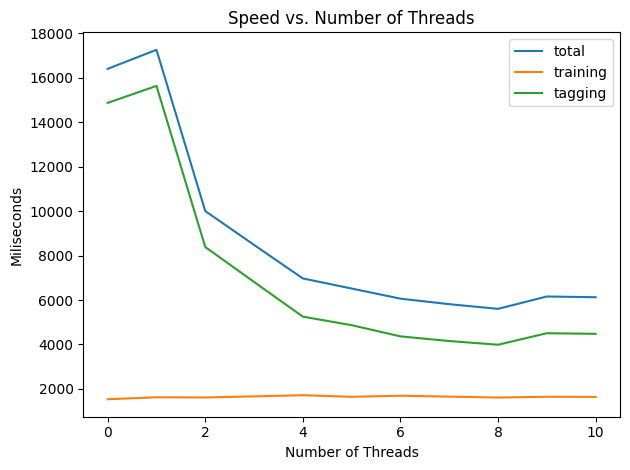

In [12]:
x_axis = range(max_num_threads + 1)
plt.plot(x_axis, all_total, label="total")
plt.plot(x_axis, all_training, label="training")
plt.plot(x_axis, all_tagging, label="tagging")
plt.ylabel("Miliseconds"), plt.xlabel("Number of Threads")
plt.title("Speed vs. Number of Threads")
plt.legend(), plt.tight_layout()
plt.show()

## Unsupervised

Training on Dev Dataset and see its log likelyhood and normalized mutual info

----

**Analysis:** We can see the log likely hood decrease and normalized mutual info score increase as the model is trained with more epochs. This means that the model learnt the POS distribution of the sentence through unsupervised learning.

In [13]:
from sklearn.metrics import normalized_mutual_info_score

def unsupervised_scores(predicts: list[list[str, float]], targets: list[list[str]]):
    predicts = [x[0] for xx in predicts for x in xx]
    targets = [x for xx in targets for x in xx]
    nmi = normalized_mutual_info_score(targets, predicts)
    return nmi

In [14]:
all_nmi, all_epochs = list(), list()
model = UnsupervisedHmmPosTagger(
    len(ALL_POS_TAGS), (x for xx in dev_set["sentences"] for x in xx), init_seed=42
)
for epoch in range(1, 100+1):
    model.fit(dev_set["sentences"])
    if epoch % 10 == 0:
        predicts = model.tag(dev_set["sentences"])
        nmi = unsupervised_scores(predicts, dev_set["labels"])
        all_nmi.append(nmi), all_epochs.append(epoch)

Log likelyhood: 46.63137435913086
Log likelyhood: -107.40145874023438
Log likelyhood: -107.39954376220703
Log likelyhood: -107.39214324951172
Log likelyhood: -107.3656997680664
Log likelyhood: -107.27882385253906
Log likelyhood: -107.03350067138672
Log likelyhood: -106.48882293701172
Log likelyhood: -105.58535766601562
Log likelyhood: -104.6337890625
Log likelyhood: -104.1026382446289
Log likelyhood: -103.9285888671875
Log likelyhood: -103.786865234375
Log likelyhood: -103.4574203491211
Log likelyhood: -102.89546203613281
Log likelyhood: -102.36548614501953
Log likelyhood: -102.08712005615234
Log likelyhood: -101.97357940673828
Log likelyhood: -101.87646484375
Log likelyhood: -101.70378112792969
Log likelyhood: -101.40496826171875
Log likelyhood: -101.0625991821289
Log likelyhood: -100.80438232421875
Log likelyhood: -100.65367889404297
Log likelyhood: -100.55486297607422
Log likelyhood: -100.44525146484375
Log likelyhood: -100.27828979492188
Log likelyhood: -100.02565002441406
Log like

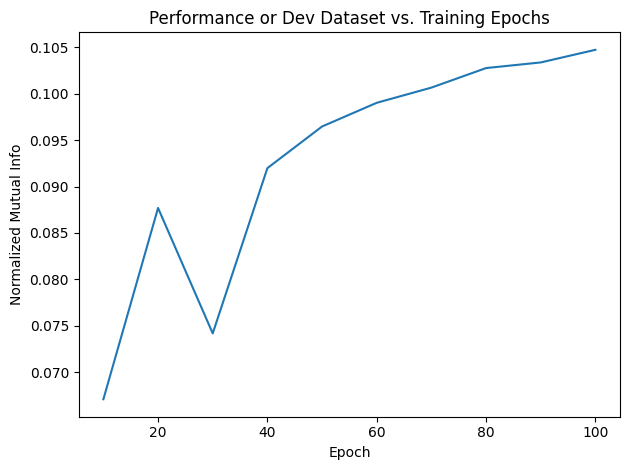

In [15]:
plt.plot(all_epochs, all_nmi)
plt.title("Performance or Dev Dataset vs. Training Epochs")
plt.ylabel("Normalized Mutual Info"), plt.xlabel("Epoch")
plt.tight_layout()
plt.show()